# Estimando Emissões de CO₂ de Data Centers no Brasil

### Integrantes
- Diego Paz Oliveira Morais  
- Sergio Augusto de Araújo  
- Ary Paulo Wiese Neto  
- Pedro Henrique Sousa dos Santos  

### Monitor
- Gabriel Brito de França

### Objetivo geral
Desenvolver um estimador exploratório (uma aplicação simples em Python) que calcule as emissões operacionais de CO₂ associadas ao consumo elétrico de data centers no Brasil, a partir de:

- dados da matriz elétrica (fatores de emissão de CO₂ por MWh);  
- dados de consumo de energia elétrica;  
- hipóteses sobre a participação dos data centers no consumo total de energia.

Ao longo do notebook, vamos:
1. Carregar e visualizar os fatores de emissão anuais (tCO₂/MWh).  
2. Carregar os dados de consumo de energia, agregando-os por ano.  
3. Relacionar consumo e fatores de emissão para obter emissões anuais totais.  
4. Estimar a parcela de emissões atribuída aos data centers.  
5. Projetar essas emissões para o futuro utilizando séries temporais e gerar gráficos de visualização.

## O Projeto

Este notebook faz parte do projeto de APC e tem como foco estimar e projetar as emissões de CO₂ associadas ao consumo de energia de data centers no Brasil.

A ideia é construir um fluxo completo de análise de dados:

1. Ler e organizar fontes de dados públicas (planilhas/CSV).  
2. Tratar e padronizar as informações (anos, unidades, tipos numéricos).  
3. Calcular indicadores de interesse (fatores de emissão, consumo anual, emissões).  
4. Aplicar um modelo simples de previsão para explorar cenários futuros.  

O resultado final é um estimador que ajuda a entender como o crescimento do consumo de data centers pode impactar o perfil de emissões do país ao longo do tempo.


### Bibliotecas

Nesta etapa importamos as bibliotecas Python que serão usadas ao longo do notebook:

- **pandas**: para carregar, tratar e manipular dados em formato de tabelas (DataFrames).  
- **matplotlib.pyplot**: para criar gráficos estáticos (linhas, pontos, etc.).  
- **numpy**: para operações numéricas e suporte a vetores/arrays.  
- **os**: para lidar com caminhos de arquivos e pastas.

A célula de código abaixo apenas prepara o ambiente, sem ainda carregar nenhum dado.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

Vamos usar a planilha de fatores de emissão de CO₂ da geração de energia elétrica no Brasil, que foi previamente convertida para o arquivo `fatores_emissao.csv`.

Este arquivo contém, para cada ano:

- o **ano de referência**;  
- o **fator de emissão médio** em tCO₂/MWh.

Na célula de código logo abaixo:

1. Carregamos o arquivo `input/fatores_emissao.csv` usando o `pandas`.  
2. Exibimos as primeiras linhas da tabela para conferir se os dados foram lidos corretamente (nomes das colunas e tipos de valores).  

Esses fatores de emissão serão a base para transformar consumo de energia (MWh) em emissões de CO₂ (tCO₂).


In [10]:
# para exibir os dados do arquivo Fatores de emissão
df = pd.read_csv("input/fatores_emissao.csv")
print(df.head(3))

    ano  fator_emissao_tCO2_MWh
0  2006                  0.3355
1  2007                  0.3227
2  2008                  0.3531


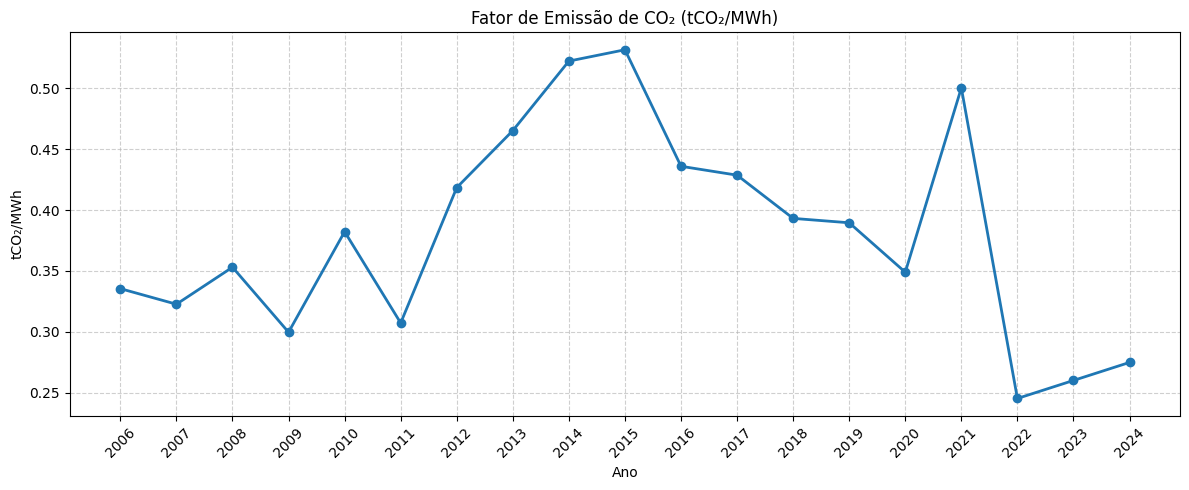

In [11]:
# Plotar o gráfico dos fatores de emissao
plt.figure(figsize=(12,5))
plt.plot(df["ano"], df["fator_emissao_tCO2_MWh"], marker='o', linewidth=2)

# Configurações do gráfico
plt.xticks(df["ano"], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Fator de Emissão de CO₂ (tCO₂/MWh)")
plt.xlabel("Ano")
plt.ylabel("tCO₂/MWh")
plt.tight_layout()

# Mostrar
plt.show()

Vamos usar também os dados de **Consumo Mensal de Energia Elétrica**, fornecidos em uma planilha Excel.

O objetivo aqui é transformar os dados mensais em uma **série anual de consumo**, para depois combiná-la com os fatores de emissão.

Na célula de código seguinte:

1. Lemos o arquivo `input/Dados_abertos_Consumo_Mensal.xlsx`.  
2. Garantimos que a coluna de consumo seja numérica (para permitir somas e cálculos).  
3. Extraímos o ano a partir da coluna de data.  
4. Filtramos o intervalo de interesse (por exemplo, de 2006 a 2024).  
5. Somamos o consumo de todos os meses de cada ano, obtendo o **consumo anual total** em MWh.

O resultado é uma tabela com duas informações principais: o ano e o consumo total daquele ano.


In [12]:
# Ler o arquivo
arquivo = "input/Dados_abertos_Consumo_Mensal.xlsx"
df = pd.read_excel(arquivo, dtype={"Data": str})

# Garantir que a coluna Consumo é numérica
df["Consumo"] = df["Consumo"].astype(float)

# Extrair o ano da coluna Data (AAAAmmdd → AAAA)
df["ano"] = df["Data"].str[:4].astype(int)

# Filtrar de 2006 a 2024
df = df[(df["ano"] >= 2006) & (df["ano"] <= 2024)]

# Somar todos os consumos do ano
df_anual = (
    df.groupby("ano")["Consumo"]
      .sum()
      .reset_index()
      .rename(columns={"Consumo": "consumo_anual_MWh"})
)

# Salvar o CSV final
os.makedirs("input", exist_ok=True)
saida = "input/consumo_anual_MWh.csv"
df_anual.to_csv(saida, index=False)

print("Arquivo gerado:", saida)
print(df_anual.head(3))
print(df_anual.tail(3))


Arquivo gerado: input/consumo_anual_MWh.csv
    ano  consumo_anual_MWh
0  2006       3.561293e+08
1  2007       3.770311e+08
2  2008       3.884724e+08
     ano  consumo_anual_MWh
16  2022       5.095962e+08
17  2023       5.319826e+08
18  2024       5.617158e+08


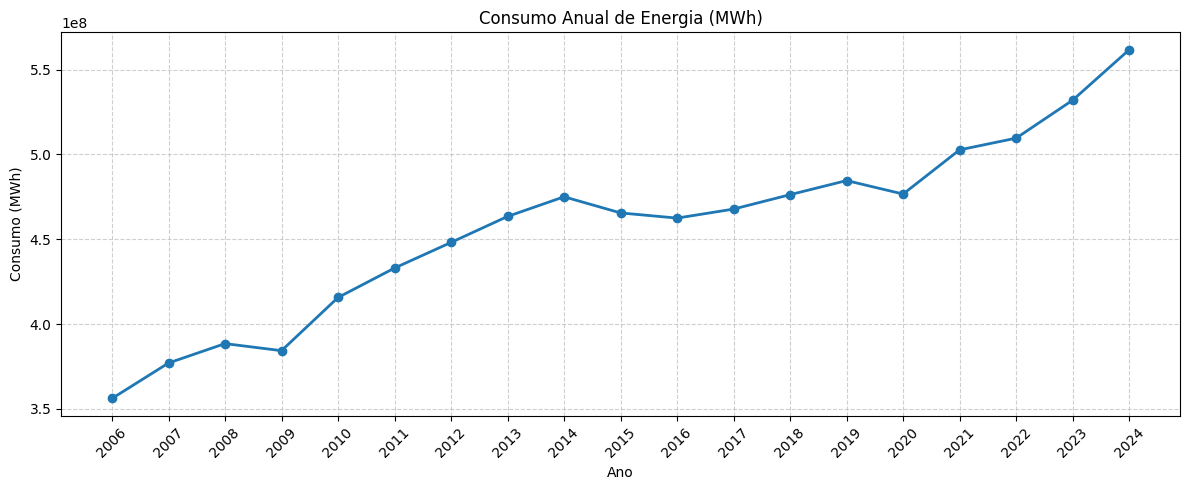

In [13]:
# Plotar o consumo anual
plt.figure(figsize=(12,5))
plt.plot(df_anual["ano"], df_anual["consumo_anual_MWh"], 
         marker='o', linewidth=2)

# Configurações do gráfico
plt.xticks(df_anual["ano"], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Consumo Anual de Energia (MWh)")
plt.xlabel("Ano")
plt.ylabel("Consumo (MWh)")
plt.tight_layout()

# Mostrar
plt.show()

Agora vamos relacionar os **fatores de emissão de CO₂** com o **consumo anual de energia**.

A ideia é:

- unir, em uma única tabela,  
  - o **fator de emissão anual (tCO₂/MWh)**;  
  - o **consumo anual de energia (MWh)**;
- a partir disso, calcular a **emissão total de CO₂ por ano**, usando a fórmula:

$\text{emissão anual (tCO₂)} = \text{consumo anual (MWh)} \times \text{fator de emissão (tCO₂/MWh)}$

Na célula de código seguinte, fazemos essa junção por ano e criamos uma coluna com o valor estimado de emissões totais do sistema elétrico.


In [14]:
# Carregar os arquivos
consumo = pd.read_csv("input/consumo_anual_MWh.csv")
fatores = pd.read_csv("input/fatores_emissao.csv")

# Garantir que a coluna 'ano' seja numérica
consumo["ano"] = consumo["ano"].astype(int)
fatores["ano"] = fatores["ano"].astype(int)

# Fazer o merge com base no ano
df_final = consumo.merge(fatores, on="ano", how="inner")

# Calcular a emissão anual em tCO2
df_final["emissao_tCO2"] = (
    df_final["consumo_anual_MWh"] * df_final["fator_emissao_tCO2_MWh"]
)

# Salvar o resultado final
df_final.to_csv("input/emissoes_anuais_2006_2024.csv", index=False)

print(df_final.head(3))

    ano  consumo_anual_MWh  fator_emissao_tCO2_MWh  emissao_tCO2
0  2006       3.561293e+08                  0.3355  1.194814e+08
1  2007       3.770311e+08                  0.3227  1.216679e+08
2  2008       3.884724e+08                  0.3531  1.371696e+08


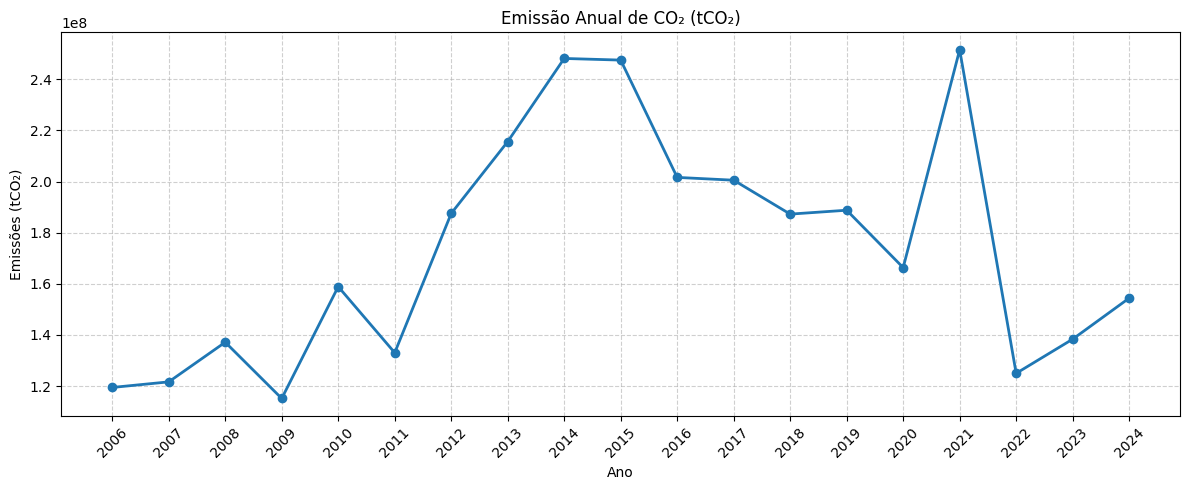

In [15]:
# Plotar a emissão anual
plt.figure(figsize=(12,5))
plt.plot(df_final["ano"], df_final["emissao_tCO2"], 
         marker='o', linewidth=2)

# Configurações do gráfico
plt.xticks(df_final["ano"], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Emissão Anual de CO₂ (tCO₂)")
plt.xlabel("Ano")
plt.ylabel("Emissões (tCO₂)")
plt.tight_layout()

# Mostrar
plt.show()

Tendo a **emissão anual total** do sistema elétrico, podemos prosseguir para as estimativas relacionadas ao **consumo de data centers**.

Para isso, usamos como referência o estudo da Brasscom sobre o [consumo de energia em data centers](https://brasscom.org.br/pdfs/consumo-de-energia-e-agua-em-data-centers/), que aponta que:

- Em **2024**, os data centers representaram cerca de **1,7%** do consumo total de energia elétrica no Brasil.  
- A projeção para **2029** é que essa participação chegue a aproximadamente **3,6%**.

No código a seguir, fazemos basicamente três coisas:

1. **Interpolamos** a participação dos data centers ao longo dos anos (por exemplo, ligando 1,7% em 2024 a 3,6% em 2029 e estendendo essa lógica até 2030).  
2. Aplicamos essa participação sobre a série de **emissões totais**, obtendo a **emissão anual atribuída apenas aos data centers**.  
3. Preparamos essa série anual de emissões de data centers para ser usada em um modelo de previsão de séries temporais (Prophet).

Com isso, passamos a ter uma série histórica de emissões específicas de data centers, pronta para ser projetada para anos futuros.

          ds  consumo_anual_MWh  fator_emissao_tCO2_MWh             y
0 2006-12-31       3.561293e+08                  0.3355  1.194814e+08
1 2007-12-31       3.770311e+08                  0.3227  1.216679e+08
2 2008-12-31       3.884724e+08                  0.3531  1.371696e+08
3 2009-12-31       3.843064e+08                  0.2997  1.151766e+08
4 2010-12-31       4.156678e+08                  0.3823  1.589098e+08


23:01:47 - cmdstanpy - INFO - Chain [1] start processing
23:01:47 - cmdstanpy - INFO - Chain [1] done processing


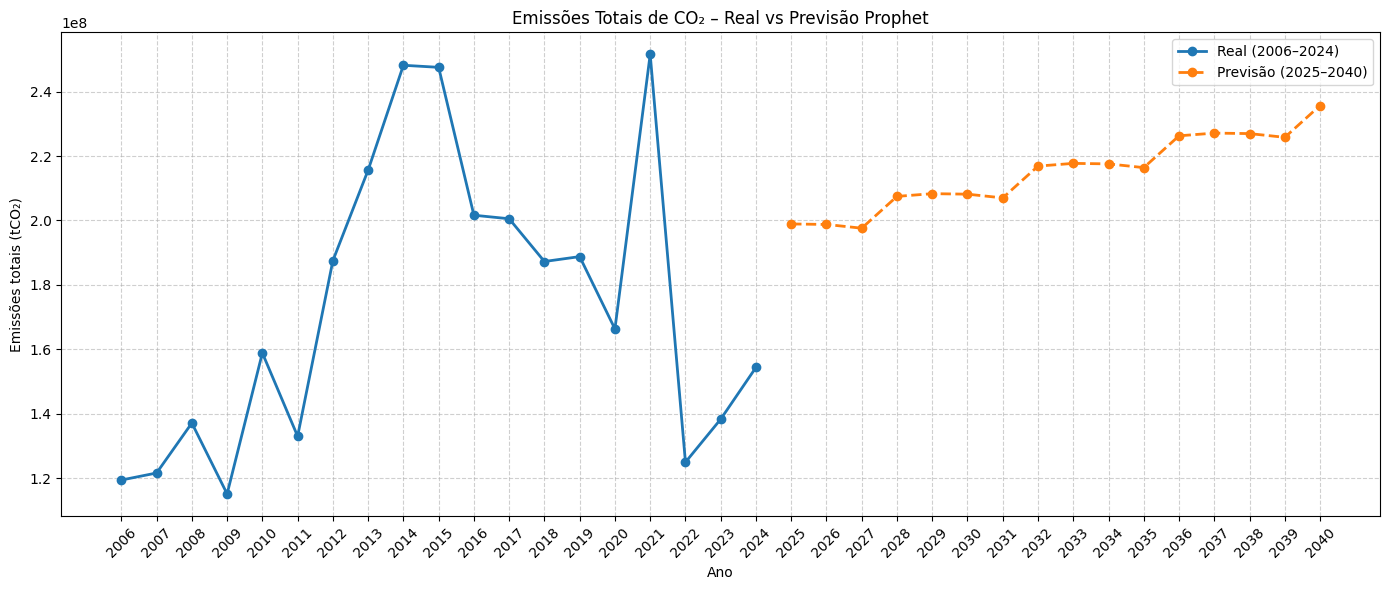


Modo 'consumo': vamos estimar o consumo dos DCs e, a partir disso, as emissões.



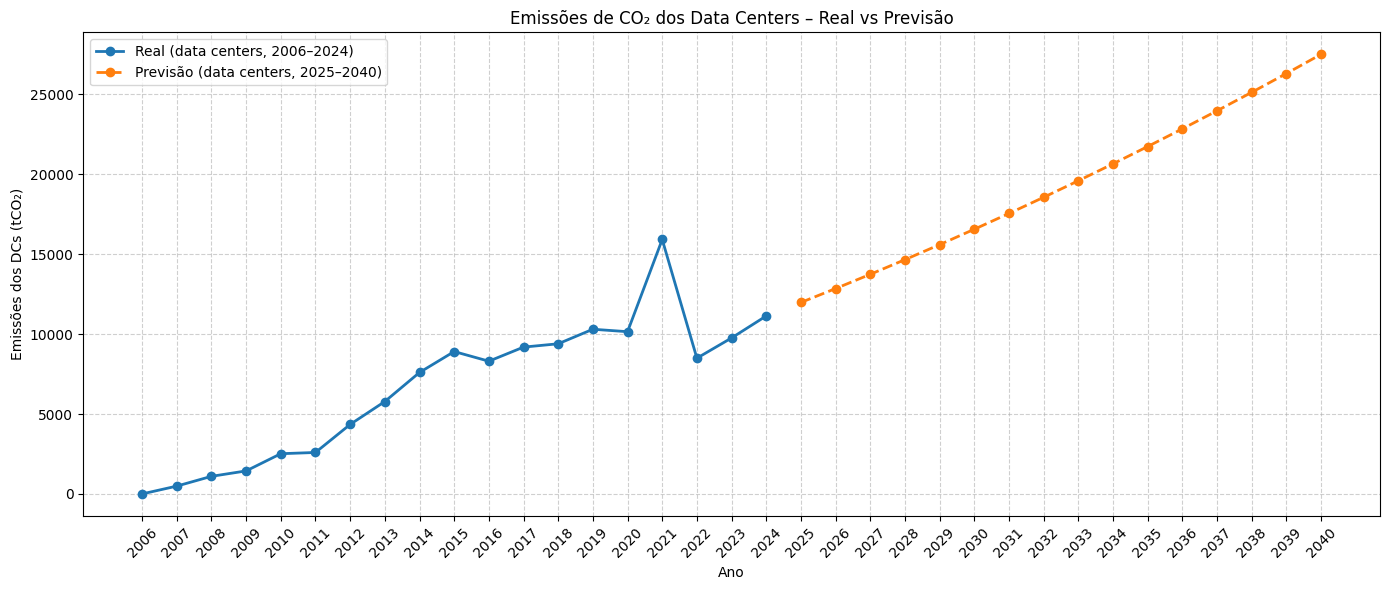

In [16]:
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1) PREPARAR SÉRIE PARA O PROPHET
# ==========================================

# df_final já contém:
# ano, consumo_anual_MWh, fator_emissao_tCO2_MWh, emissao_tCO2

df = df_final.copy()

# Renomear para o padrão exigido pelo Prophet
df_prophet = df.rename(columns={
    "ano": "ds",
    "emissao_tCO2": "y"
})

# Converter ano (inteiro) para datetime (Prophet exige datas)
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"].astype(str) + "-12-31")

print(df_prophet.head())

# Último ano histórico (deve ser 2024)
ultimo_ano_hist = df_prophet["ds"].dt.year.max()
ano_inicio = df_prophet["ds"].dt.year.min()

# ==========================================
# 2) INPUTS DE CENÁRIO
# ==========================================

ano_fim = int(input(
    f"Até que ano você quer projetar as emissões? "
    f"(mínimo {ultimo_ano_hist}, ex: 2030 ou 2035) "
))

if ano_fim < ultimo_ano_hist:
    raise ValueError(
        f"ano_fim ({ano_fim}) não pode ser menor que o último ano histórico "
        f"({ultimo_ano_hist}). Escolha um ano >= {ultimo_ano_hist}."
    )

modo_dc = input(
    "Como você quer definir o cenário dos data centers? "
    "[percentual/consumo] "
).strip().lower()

# Parâmetros fixos conhecidos
ano_ref_2024 = 2024
participacao_inicio = 0.003   # 0,3% em 2006 (hipótese)
participacao_2024   = 0.017   # 1,7% em 2024 (Brasscom)

# ==========================================
# 3) TREINAR O PROPHET E GERAR PREVISÃO TOTAL
# ==========================================

model = Prophet()
model.fit(df_prophet)

periods = ano_fim - ultimo_ano_hist

future = model.make_future_dataframe(
    periods=periods,
    freq="YE"   # fim de ano (31/12)
)

forecast = model.predict(future)

# ==========================================
# 4) GRÁFICO – EMISSÃO TOTAL (REAL x PREVISÃO)
# ==========================================

df_real_total = df_prophet.copy()
df_real_total["ano"] = df_real_total["ds"].dt.year

df_prev_total = forecast[["ds", "yhat"]].copy()
df_prev_total["ano"] = df_prev_total["ds"].dt.year
df_prev_total = df_prev_total[df_prev_total["ano"] > ultimo_ano_hist]
df_prev_total = df_prev_total[df_prev_total["ano"] <= ano_fim]

plt.figure(figsize=(14,6))

plt.plot(
    df_real_total["ano"],
    df_real_total["y"],
    marker="o",
    linewidth=2,
    label=f"Real ({ano_inicio}–{ultimo_ano_hist})"
)

if not df_prev_total.empty:
    plt.plot(
        df_prev_total["ano"],
        df_prev_total["yhat"],
        marker="o",
        linestyle="--",
        linewidth=2,
        label=f"Previsão ({ultimo_ano_hist+1}–{ano_fim})"
    )

plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(list(range(ano_inicio, ano_fim + 1)), rotation=45)
plt.title("Emissões Totais de CO₂ – Real vs Previsão Prophet")
plt.xlabel("Ano")
plt.ylabel("Emissões totais (tCO₂)")
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================
# 5) SÉRIE ÚNICA: REAL + PREVISTA (EMISSÃO TOTAL)
# ==========================================

previsao = forecast[["ds", "yhat"]].copy()
previsao["ano"] = previsao["ds"].dt.year

# manter apenas ano_inicio..ano_fim
previsao = previsao[previsao["ano"].between(ano_inicio, ano_fim)].copy()

# Pegar ano + emissão total real
hist = df_final[["ano", "emissao_tCO2"]].copy()
hist = hist[hist["ano"].between(ano_inicio, ultimo_ano_hist)].copy()

# Juntar real com previsto
previsao = previsao.merge(hist, on="ano", how="left")

# emissao_tCO2_real (quando existe) OU yhat (quando não tem real)
previsao["emissao_total_tCO2"] = previsao["emissao_tCO2"].fillna(previsao["yhat"])

previsao = previsao.sort_values("ano").reset_index(drop=True)

anos = previsao["ano"].values.astype(float)

# ==========================================
# 6) CENÁRIOS PARA OS DATA CENTERS
# ==========================================

if modo_dc == "percentual":
    # -------------------------------
    # MODO 1: DEFININDO A % EM ano_fim
    # -------------------------------
    participacao_final_percent = float(
        input(
            f"Qual a participação dos DCs em {ano_fim} (em %)? "
            f"(ex: 3.6 para 3,6%) "
        )
    )
    participacao_final = participacao_final_percent / 100.0

    participacao = np.zeros_like(anos, dtype=float)

    # 2006 → 2024: de 0,3% para 1,7%
    mask_ate_2024 = anos <= ano_ref_2024
    denom1 = ano_ref_2024 - ano_inicio

    participacao[mask_ate_2024] = participacao_inicio + (
        (participacao_2024 - participacao_inicio)
        * (anos[mask_ate_2024] - ano_inicio)
        / denom1
    )

    # 2024 → ano_fim: de 1,7% para participação_final
    mask_depois_2024 = anos > ano_ref_2024
    if ano_fim > ano_ref_2024 and mask_depois_2024.any():
        denom2 = ano_fim - ano_ref_2024
        participacao[mask_depois_2024] = participacao_2024 + (
            (participacao_final - participacao_2024)
            * (anos[mask_depois_2024] - ano_ref_2024)
            / denom2
        )

    previsao["participacao_DC"] = participacao

    # Emissões dos DCs
    previsao["emissao_DC_tCO2"] = (
        previsao["emissao_total_tCO2"] * previsao["participacao_DC"]
    )

elif modo_dc == "consumo":
    # -------------------------------
    # MODO 2: Nº DE DCs + CONSUMO MÉDIO
    # -------------------------------
    print("\nModo 'consumo': vamos estimar o consumo dos DCs e, a partir disso, as emissões.\n")

    # nº de data centers em 2006 e em ano_fim
    n_dc_inicio = int(input(f"Quantos data centers você supõe em {ano_inicio}? "))
    n_dc_fim    = int(input(f"Quantos data centers você supõe em {ano_fim}? "))

    # consumo médio anual por DC (MWh/ano)
    cons_dc_inicio = float(input(
        f"Qual o consumo médio anual por DC em {ano_inicio} (MWh/ano)? "
    ))
    cons_dc_fim = float(input(
        f"Qual o consumo médio anual por DC em {ano_fim} (MWh/ano)? "
    ))

    # interpolar ao longo dos anos
    previsao["n_datacenters"] = np.interp(
        anos,
        [ano_inicio, ano_fim],
        [n_dc_inicio, n_dc_fim]
    )

    previsao["consumo_medio_DC_MWh"] = np.interp(
        anos,
        [ano_inicio, ano_fim],
        [cons_dc_inicio, cons_dc_fim]
    )

    # consumo total dos DCs (MWh)
    previsao["consumo_DC_MWh"] = (
        previsao["n_datacenters"] * previsao["consumo_medio_DC_MWh"]
    )

    # fator de emissão tCO2/MWh para cada ano
    fatores = df_final[["ano", "fator_emissao_tCO2_MWh"]].drop_duplicates()
    fatores = fatores[fatores["ano"].between(ano_inicio, ultimo_ano_hist)]
    previsao = previsao.merge(fatores, on="ano", how="left")

    # para anos > último histórico, usar o último fator conhecido
    previsao["fator_emissao_tCO2_MWh"] = (
        previsao["fator_emissao_tCO2_MWh"].ffill().bfill()
    )

    # emissões dos DCs = consumo_DC_MWh * fator_emissao
    previsao["emissao_DC_tCO2"] = (
        previsao["consumo_DC_MWh"] * previsao["fator_emissao_tCO2_MWh"]
    )

    # participação resultante (pode ser >, < ou ~= à curva percentual)
    previsao["participacao_DC"] = (
        previsao["emissao_DC_tCO2"] / previsao["emissao_total_tCO2"]
    )

else:
    raise ValueError("Modo inválido. Use 'percentual' ou 'consumo'.")

# ==========================================
# 7) SEPARAR REAL x PREVISÃO DOS DCs
# ==========================================

df_real_dc = previsao[previsao["ano"] <= ultimo_ano_hist].copy()
df_prev_dc = previsao[previsao["ano"] > ultimo_ano_hist].copy()

# ==========================================
# 8) GRÁFICO – EMISSÕES DOS DATA CENTERS
# ==========================================

plt.figure(figsize=(14,6))

plt.plot(
    df_real_dc["ano"],
    df_real_dc["emissao_DC_tCO2"],
    marker="o",
    linewidth=2,
    label=f"Real (data centers, {ano_inicio}–{ultimo_ano_hist})"
)

if not df_prev_dc.empty:
    plt.plot(
        df_prev_dc["ano"],
        df_prev_dc["emissao_DC_tCO2"],
        marker="o",
        linestyle="--",
        linewidth=2,
        label=f"Previsão (data centers, {ultimo_ano_hist+1}–{ano_fim})"
    )

plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(list(range(ano_inicio, ano_fim + 1)), rotation=45)
plt.title("Emissões de CO₂ dos Data Centers – Real vs Previsão")
plt.xlabel("Ano")
plt.ylabel("Emissões dos DCs (tCO₂)")
plt.legend()
plt.tight_layout()
plt.show()
